Мною был выбран датасет из соревнования, которое уже закончилось, по предскаанию времени (в милллисекундах), за которое гонщик проехал круг на болиде формулы 1 в гонках с 1993 по 2023 год. Выбрал такие данные, т.к. являюсь любителем автоспорта.

In [1]:
! pip install -q kaggle

In [2]:
! pip install torchinfo --quiet

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"victorbratko","key":"afcdad0dd6172153dfade38a929d5780"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c formula-1-lap-time-prediction-nwvs-s00e02

  0% 0.00/0.98M [00:00<?, ?B/s]
100% 0.98M/0.98M [00:00<00:00, 85.9MB/s]


In [6]:
! unzip  '/content/formula-1-lap-time-prediction-nwvs-s00e02.zip' -d '/content/formula-1-lap-time-prediction-nwvs-s00e02'

Archive:  /content/formula-1-lap-time-prediction-nwvs-s00e02.zip
  inflating: /content/formula-1-lap-time-prediction-nwvs-s00e02/sample_submission.csv  
  inflating: /content/formula-1-lap-time-prediction-nwvs-s00e02/test.csv  
  inflating: /content/formula-1-lap-time-prediction-nwvs-s00e02/train.csv  


In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [197]:
df = pd.read_csv("/content/formula-1-lap-time-prediction-nwvs-s00e02/train.csv")
df.head()

,id,race,date,time,circuit,latitude,longitude,altitude,driver,carNumber,constructor,avgDriverFinish,avgConstructorFinish,lapNumber,lapPosition,pitStop,pitCount,pitTime_ms,lapTime_ms
0,1,British Grand Prix,2017-07-16,12:00:00,Silverstone Circuit,52.0786,-1.01694,153,"Ricciardo, Daniel",3,Red Bull,9.799145,3.033426,18,10,0,0,0.0,94846
1,2,Australian Grand Prix,2023-04-02,05:00:00,Albert Park Grand Prix Circuit,-37.8497,144.96800,10,"Hülkenberg, Nico",27,Haas F1 Team,12.418502,7.871795,13,7,0,1,0.0,83719
2,3,Mexican Grand Prix,2019-10-27,19:10:00,Autódromo Hermanos Rodríguez,19.4042,-99.09070,2227,"Magnussen, Kevin",20,Haas F1 Team,13.808140,7.871795,46,16,0,1,0.0,82213
3,4,United States Grand Prix,2000-09-24,NaN,Indianapolis Motor Speedway,39.7950,-86.23470,223,"Mazzacane, Gastón",21,Minardi,21.468750,10.394659,42,13,0,0,0.0,76951
4,5,Hungarian Grand Prix,2011-07-31,12:00:00,Hungaroring,47.5789,19.24860,264,"d'Ambrosio, Jérôme",25,Virgin,21.518519,11.736842,48,19,0,3,0.0,151214


id - unique identifier for the driver and lap

race - name of the race

date - date of the race (yyyy-mm-dd)

time - time of the race (hh:mm:ss)

circuit - name of the circuit

latitude - latitude of the circuit

longitude - longitude of the circuit

altitude - altitude of the circuit

driver - name of the driver

carNumber - number of the car

constructor - name of the constructor

avgDriverFinish - average finishing position of the driver

avgConstructorFinish - average finishing position of the constructor

lapNumber - lap number of the race

lapPosition - position of the driver at lap number

pitStop - 1 = pit stop on the lap, 0 = no pit stop on the lap

pitCount - cumulative count of driver's pit stops during race

pitTime_ms - time of the pit stop

lapTime_ms - time of the lap in milliseconds (TARGET)

опираясь на логику и некоторые знания, можно удалить следующие признаки:
- id
- race - у нас и так в датасете есть признак с названием гоночных трасс, поэтому столбец с названием страны где проходит гонка не только дублирует информацию, но дает не точную информацию, потому что в один год гонка может называться по одному, в другой по другому, хотя трасса на которой ее проводят, может быть одной и той же
- latitude, longitude, attitude - у нас есть название трассы в признаках. Т.к. трассу не переносят каждый год, то ее координаты никак не добавляют информации о скорости на круге и по сути также копируют столбец с названием атодрома
- carNumber - этот признак копирует признак driver (нам интересно кто сидит за рулем в болиде, не его номер, который никак не влияет на скорость)

In [198]:
delete_features = ["id", "race", "latitude", "longitude", "altitude", "carNumber"]
df.drop(columns=delete_features, inplace=True)
df

,date,time,circuit,driver,constructor,avgDriverFinish,avgConstructorFinish,lapNumber,lapPosition,pitStop,pitCount,pitTime_ms,lapTime_ms
0,2017-07-16,12:00:00,Silverstone Circuit,"Ricciardo, Daniel",Red Bull,9.799145,3.033426,18,10,0,0,0.0,94846
1,2023-04-02,05:00:00,Albert Park Grand Prix Circuit,"Hülkenberg, Nico",Haas F1 Team,12.418502,7.871795,13,7,0,1,0.0,83719
2,2019-10-27,19:10:00,Autódromo Hermanos Rodríguez,"Magnussen, Kevin",Haas F1 Team,13.808140,7.871795,46,16,0,1,0.0,82213
3,2000-09-24,NaN,Indianapolis Motor Speedway,"Mazzacane, Gastón",Minardi,21.468750,10.394659,42,13,0,0,0.0,76951
4,2011-07-31,12:00:00,Hungaroring,"d'Ambrosio, Jérôme",Virgin,21.518519,11.736842,48,19,0,3,0.0,151214
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2021-06-06,12:00:00,Baku City Circuit,"Alonso, Fernando",Alpine F1 Team,7.448925,5.303571,39,11,0,2,0.0,106314
29996,2016-04-17,06:00:00,Shanghai International Circuit,"Rosberg, Nico",Mercedes,6.766990,2.199262,53,1,0,2,0.0,100814
29997,2002-06-23,NaN,Nürburgring,"Trulli, Jarno",Renault,11.580000,5.199507,40,6,0,0,0.0,95675
29998,2014-11-02,20:00:00,Circuit of the Americas,"Rosberg, Nico",Mercedes,6.766990,2.199262,13,1,0,0,0.0,104406


Посмотрим сколько пропущено данных в каждом столбце

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  30000 non-null  object 
 1   time                  22965 non-null  object 
 2   circuit               30000 non-null  object 
 3   driver                30000 non-null  object 
 4   constructor           30000 non-null  object 
 5   avgDriverFinish       30000 non-null  float64
 6   avgConstructorFinish  30000 non-null  float64
 7   lapNumber             30000 non-null  int64  
 8   lapPosition           30000 non-null  int64  
 9   pitStop               30000 non-null  int64  
 10  pitCount              30000 non-null  int64  
 11  pitTime_ms            30000 non-null  float64
 12  lapTime_ms            30000 non-null  int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 3.0+ MB


In [200]:
(df.isna().sum() * 100 / len(df)).sort_values()[-1:0:-1].head(3)

time          23.45
lapTime_ms     0.00
pitTime_ms     0.00
dtype: float64

Заполним пропуски в колонке времени средним значением, объединим дату и время в один столбец, а старые колонки удалим

In [201]:
df["date"] = pd.to_datetime(df["date"])
df["time"] = pd.to_datetime(df["time"], format="%H:%M:%S", errors="coerce")
df["time"].fillna(df["time"].mean(), inplace=True)
df["datetime"] = df["date"] + pd.to_timedelta(df["time"].dt.strftime("%H:%M:%S"))
df.drop(columns=["date", "time"], inplace=True)

In [202]:
(df.isna().sum() * 100 / len(df)).sort_values()[-1:0:-1].head(3)

datetime      0.0
lapTime_ms    0.0
pitTime_ms    0.0
dtype: float64

In [203]:
df_time = df[["datetime", "lapTime_ms"]]
df_time["datetime"] = df_time["datetime"].dt.year
df_time = df_time.groupby("datetime").mean()

<ipython-input-203-75ddc168e120>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time["datetime"] = df_time["datetime"].dt.year


Text(0, 0.5, 'lap time per ms')

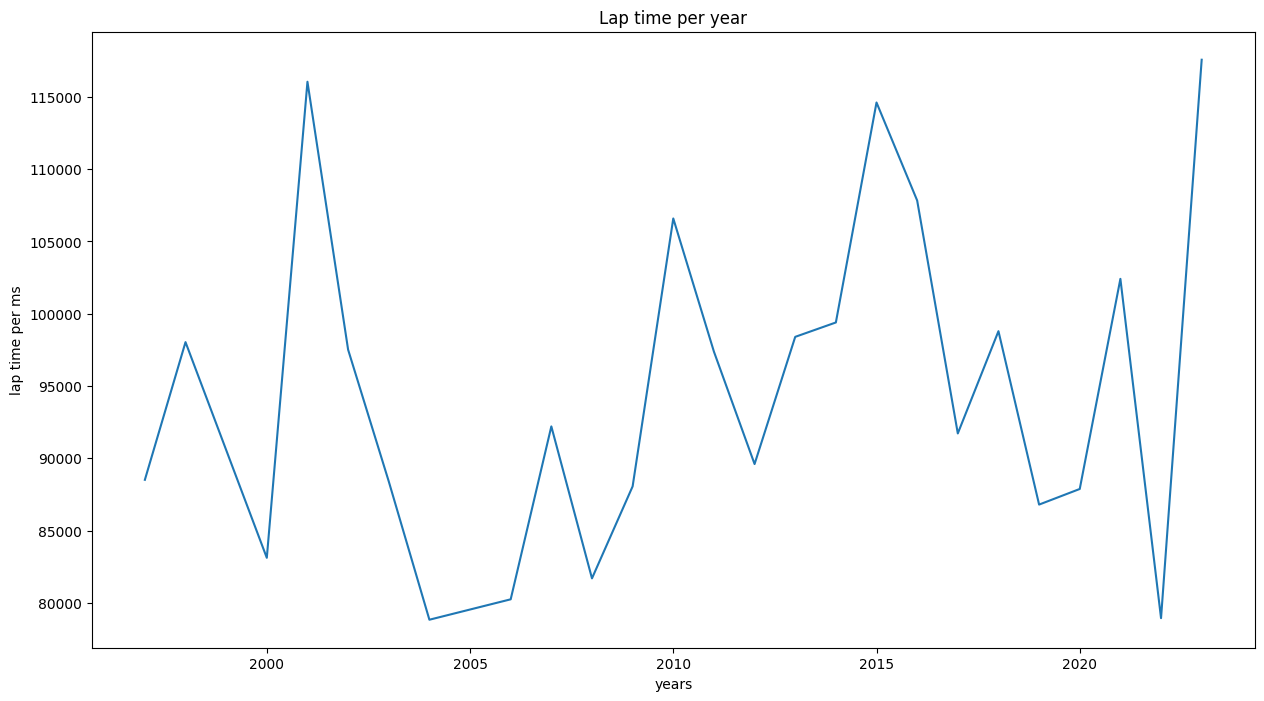

In [204]:
plt.figure()
sns.lineplot(data=df_time, x="datetime", y="lapTime_ms")
plt.title("Lap time per year")
plt.xlabel("years")
plt.ylabel("lap time per ms")

на данном графике можно заметить одну логичную и закономерную вещь - время на круге увеличивается в те года, когда происходит смена технического регламента и инженерам заново необходимо искать решения, чтобы машина быстрее ехала, и уменьшается, когда технический регламент остается прежним

Теперь закодируем категориальные признаки one-hot encoding, а затем стандартизируем данные и разобьем на тренировочные, валидационные и тестовые.
Т.к. мы не можем стандартизировать числове данные, то переведем их в числовой формат

In [205]:
categorical_features = ["circuit", "driver", "constructor", "pitStop"]

for feature in categorical_features:
  dummies = pd.get_dummies(df[feature], prefix=feature, drop_first=False, dtype=float)
  df = pd.concat([df, dummies], axis=1)
df = df.drop(categorical_features, axis = 1)

Также переведем время в секунды и удалим аномалии (время пит стопа не может занимать больше, чем половина всего времени на круге и время на круге обычно намного меньше, чем 3 минуты)

In [206]:
df["datetime"] = df["datetime"].astype(int) // 10**16

In [207]:
df["lapTime_sec"] = df["lapTime_ms"] / 10**3
df["pitTime_sec"] = df["pitTime_ms"] / 10**3
df.drop(columns=["lapTime_ms", "pitTime_ms"], inplace=True)

In [208]:
df = df.where(df["pitTime_sec"] < df["lapTime_sec"] * 0.5).dropna()
df = df.where(df["lapTime_sec"] < 180).dropna()

In [209]:
df.sort_values(by="datetime", inplace=True)
df

,avgDriverFinish,avgConstructorFinish,lapNumber,lapPosition,pitCount,datetime,circuit_Albert Park Grand Prix Circuit,circuit_Autodromo Nazionale di Monza,circuit_Autódromo Hermanos Rodríguez,circuit_Autódromo Internacional do Algarve,...,constructor_Super Aguri,constructor_Toro Rosso,constructor_Toyota,constructor_Tyrrell,constructor_Virgin,constructor_Williams,pitStop_0,pitStop_1,lapTime_sec,pitTime_sec
29999,4.325879,2.833984,16.0,7.0,0.0,87.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,87.347,0.0
11099,8.756494,7.000000,14.0,15.0,0.0,87.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,88.122,0.0
26590,22.160000,10.394659,12.0,20.0,0.0,87.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,90.897,0.0
23553,9.369231,3.822394,39.0,2.0,0.0,87.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,86.592,0.0
26617,11.580000,8.329268,18.0,12.0,0.0,87.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,87.744,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12160,13.308511,2.199262,5.0,1.0,0.0,168.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,83.134,0.0
12141,6.394366,8.700483,58.0,12.0,6.0,168.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,154.815,0.0
23007,11.066116,5.303571,11.0,9.0,0.0,168.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,93.836,0.0
12240,11.357724,5.303571,2.0,12.0,0.0,168.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,95.230,0.0


In [210]:
continuous_features = ["avgDriverFinish", "avgConstructorFinish", "lapNumber", "lapPosition", "pitCount", "pitTime_sec", "datetime"]
scaled_features = {}

for feature in continuous_features:
  std, mean = df[feature].mean(), df[feature].std()
  scaled_features[feature] = [mean, std]
  df.loc[:, feature] = (df[feature] - mean) / std

scaled_features

{'avgDriverFinish': [4.709719178864241, 11.023146293134339],
 'avgConstructorFinish': [2.379429944516853, 5.612842902829159],
 'lapNumber': [18.349048884620007, 30.019803305011038],
 'lapPosition': [5.559935521757417, 9.748544858500033],
 'pitCount': [1.0155613685309794, 0.740349233959992],
 'pitTime_sec': [3.4712322444159467, 0.5043456880979461],
 'datetime': [23.731321988806574, 135.21536094199504]}

In [211]:
df.head()

,avgDriverFinish,avgConstructorFinish,lapNumber,lapPosition,pitCount,datetime,circuit_Albert Park Grand Prix Circuit,circuit_Autodromo Nazionale di Monza,circuit_Autódromo Hermanos Rodríguez,circuit_Autódromo Internacional do Algarve,...,constructor_Super Aguri,constructor_Toro Rosso,constructor_Toyota,constructor_Tyrrell,constructor_Virgin,constructor_Williams,pitStop_0,pitStop_1,lapTime_sec,pitTime_sec
29999,-0.034821,0.080985,-0.078250,0.147721,-1.371733,0.46791,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,87.347,-6.882645
11099,0.367116,0.823214,-0.144873,0.968356,-1.371733,0.46791,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,88.122,-6.882645
26590,1.583058,1.428016,-0.211495,1.481253,-1.371733,0.46791,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,90.897,-6.882645
23553,0.422703,0.257083,0.687911,-0.365176,-1.371733,0.46791,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,86.592,-6.882645
26617,0.623260,1.060040,-0.011627,0.660618,-1.371733,0.46791,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,87.744,-6.882645


In [212]:
y = df["lapTime_sec"]
X = df.drop(columns=["lapTime_sec"])

Отдадим 5% на тест и 15% от оставшегося количества на валидацию

In [214]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

In [215]:
val_num = 0.15
X_validation = X_train[int((1 - val_num) * len(X_train)):]
y_validation = y_train[int((1 - val_num) * len(y_train)):]
X_train = X_train[:int((1 - val_num) * len(X_train))]
y_train = y_train[:int((1 - val_num) * len(y_train))]
print(len(X_train) + len(X_validation) + len(X_test) == len(X))

True


Перейдем к создании модели. Для начала создадим datasets и dataloader

In [216]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision.transforms as T

In [217]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cpu'

In [218]:
class MyDataset(Dataset):
  def __init__(self, data, targets, transformation=None):
    self.data = torch.FloatTensor(data)
    self.targets = torch.FloatTensor(targets)
    self.transformation = transformation

  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]
    return x, y

  def __len__(self):
    return len(self.data)


In [219]:
train_dataset = MyDataset(X_train.values, y_train.values)
validation_dataset = MyDataset(X_validation.values, y_validation.values)
test_dataset = MyDataset(X_test.values, y_test.values)

In [220]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)

Сначала построим базовую модель, от которой будем отталкиваться и сравнивать результат прокаченной модели


In [221]:
class SimpleNN(nn.Module):
  def __init__(self, num_inputs, num_output=1):
    super().__init__()

    self.activation = nn.ReLU(inplace=True)

    self.linear1 = nn.Linear(num_inputs, 256)
    self.linear2 = nn.Linear(256, 128)
    self.linear3 = nn.Linear(128, 32)
    self.linear4 = nn.Linear(32, num_output)

  def forward(self, x):
    out = self.linear1(x)
    out = self.activation(out)

    out = self.linear2(out)
    out = self.activation(out)

    out = self.linear3(out)
    out = self.activation(out)

    out = self.linear4(out)

    return out


In [222]:
num_inputs = train_dataset[0][0].shape[0]
simple_model = SimpleNN(num_inputs, 1).to(device)

In [223]:
from torchinfo import summary
summary(simple_model, input_size=(1, num_inputs))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleNN                                 [1, 1]                    --
├─Linear: 1-1                            [1, 256]                  49,152
├─ReLU: 1-2                              [1, 256]                  --
├─Linear: 1-3                            [1, 128]                  32,896
├─ReLU: 1-4                              [1, 128]                  --
├─Linear: 1-5                            [1, 32]                   4,128
├─ReLU: 1-6                              [1, 32]                   --
├─Linear: 1-7                            [1, 1]                    33
Total params: 86,209
Trainable params: 86,209
Non-trainable params: 0
Total mult-adds (M): 0.09
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.34
Estimated Total Size (MB): 0.35

In [224]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=1e-5, betas=(0.9, 0.999))

In [225]:
from tqdm import tqdm

In [226]:
def MAE(predictions, targets):
  result = abs(predictions.detach().cpu().numpy() - targets.detach().cpu().numpy())
  return result.mean()

In [227]:
train_loss = []
MAE_train_loss = []
def train(model):
  model.train()
  current_loss = 0
  current_mae = 0
  for data in tqdm(train_loader):
    inputs, targets = data[0].to(device), data[1].view(-1, 1).to(device)
    criterion.zero_grad()
    predictions = model(inputs)
    loss = criterion(predictions, targets)
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    current_mae += MAE(predictions, targets)

  train_loss.append(current_loss / len(train_dataset))
  MAE_train_loss.append(current_mae / len(train_dataset))

  print(f"train loss: {current_loss / len(train_dataset):.3f}")
  print(f"train MAE: {current_mae / len(train_dataset):.3f}")

In [228]:
validation_loss = []
MAE_validation_loss = []
def validation(model):
  model.eval()
  current_loss = 0
  current_mae = 0
  with torch.no_grad():
    for data in tqdm(validation_loader):
      inputs, targets = data[0].to(device), data[1].view(-1, 1).to(device)
      predictions = model(inputs)
      loss = criterion(predictions, targets)
      current_loss += loss.item()
      current_mae += MAE(predictions, targets)

    validation_loss.append(current_loss / len(validation_dataset))
    MAE_validation_loss.append(current_mae / len(validation_dataset))

    print(f"validation loss: {current_loss / len(validation_dataset):.3f}")
    print(f"validation MAE: {current_mae / len(validation_dataset):.3f}")

In [250]:
MAE_test_loss = []
results = []
def test(model):
  i = 0
  model.eval()
  current_loss = 0
  current_mae = 0
  with torch.no_grad():
    for data in tqdm(test_loader):
      i += 1
      inputs, targets = data[0].to(device), data[1].view(-1, 1).to(device)
      predictions = model(inputs)
      loss = criterion(predictions, targets)
      current_loss += loss.item()
      current_mae += MAE(predictions, targets)
      MAE_test_loss.append(current_mae / i)
      results.extend(predictions)

    print(f"test loss: {current_loss / len(test_loader):.3f}")
    print(f"test MAE: {(current_mae / len(test_loader)):.3f} seconds")

In [230]:
epochs = 40
for epoch in range(1, epochs + 1):
  print(f"Epoch №{epoch}")
  train(simple_model)
  validation(simple_model)

Epoch №1


100%|██████████| 378/378 [00:01<00:00, 216.20it/s]


train loss: 139.616
train MAE: 1.463


100%|██████████| 67/67 [00:00<00:00, 798.50it/s]


validation loss: 113.366
validation MAE: 1.311
Epoch №2


100%|██████████| 378/378 [00:02<00:00, 185.84it/s]


train loss: 138.274
train MAE: 1.456


100%|██████████| 67/67 [00:00<00:00, 449.95it/s]


validation loss: 111.462
validation MAE: 1.300
Epoch №3


100%|██████████| 378/378 [00:01<00:00, 208.44it/s]


train loss: 134.735
train MAE: 1.436


100%|██████████| 67/67 [00:00<00:00, 811.32it/s]


validation loss: 107.034
validation MAE: 1.273
Epoch №4


100%|██████████| 378/378 [00:01<00:00, 253.00it/s]


train loss: 127.532
train MAE: 1.397


100%|██████████| 67/67 [00:00<00:00, 789.70it/s]


validation loss: 98.856
validation MAE: 1.221
Epoch №5


100%|██████████| 378/378 [00:01<00:00, 264.31it/s]


train loss: 115.390
train MAE: 1.327


100%|██████████| 67/67 [00:00<00:00, 759.01it/s]


validation loss: 86.413
validation MAE: 1.138
Epoch №6


100%|██████████| 378/378 [00:01<00:00, 259.40it/s]


train loss: 98.091
train MAE: 1.220


100%|██████████| 67/67 [00:00<00:00, 787.55it/s]


validation loss: 69.820
validation MAE: 1.016
Epoch №7


100%|██████████| 378/378 [00:01<00:00, 268.73it/s]


train loss: 76.388
train MAE: 1.070


100%|██████████| 67/67 [00:00<00:00, 761.20it/s]


validation loss: 50.536
validation MAE: 0.851
Epoch №8


100%|██████████| 378/378 [00:01<00:00, 249.77it/s]


train loss: 52.335
train MAE: 0.875


100%|██████████| 67/67 [00:00<00:00, 788.55it/s]


validation loss: 31.025
validation MAE: 0.647
Epoch №9


100%|██████████| 378/378 [00:01<00:00, 216.24it/s]


train loss: 29.499
train MAE: 0.639


100%|██████████| 67/67 [00:00<00:00, 537.00it/s]


validation loss: 14.986
validation MAE: 0.408
Epoch №10


100%|██████████| 378/378 [00:02<00:00, 182.60it/s]


train loss: 12.309
train MAE: 0.371


100%|██████████| 67/67 [00:00<00:00, 800.22it/s]


validation loss: 6.507
validation MAE: 0.198
Epoch №11


100%|██████████| 378/378 [00:01<00:00, 257.82it/s]


train loss: 5.182
train MAE: 0.207


100%|██████████| 67/67 [00:00<00:00, 823.05it/s]


validation loss: 8.967
validation MAE: 0.314
Epoch №12


100%|██████████| 378/378 [00:01<00:00, 263.09it/s]


train loss: 10.761
train MAE: 0.343


100%|██████████| 67/67 [00:00<00:00, 847.90it/s]


validation loss: 22.791
validation MAE: 0.545
Epoch №13


100%|██████████| 378/378 [00:01<00:00, 263.53it/s]


train loss: 26.833
train MAE: 0.596


100%|██████████| 67/67 [00:00<00:00, 721.98it/s]


validation loss: 41.931
validation MAE: 0.768
Epoch №14


100%|██████████| 378/378 [00:01<00:00, 265.39it/s]


train loss: 42.818
train MAE: 0.775


100%|██████████| 67/67 [00:00<00:00, 812.77it/s]


validation loss: 51.561
validation MAE: 0.859
Epoch №15


100%|██████████| 378/378 [00:01<00:00, 270.49it/s]


train loss: 42.264
train MAE: 0.766


100%|██████████| 67/67 [00:00<00:00, 803.07it/s]


validation loss: 39.060
validation MAE: 0.741
Epoch №16


100%|██████████| 378/378 [00:01<00:00, 266.61it/s]


train loss: 23.698
train MAE: 0.552


100%|██████████| 67/67 [00:00<00:00, 720.07it/s]


validation loss: 17.572
validation MAE: 0.480
Epoch №17


100%|██████████| 378/378 [00:02<00:00, 188.65it/s]


train loss: 7.789
train MAE: 0.290


100%|██████████| 67/67 [00:00<00:00, 421.56it/s]


validation loss: 6.247
validation MAE: 0.264
Epoch №18


100%|██████████| 378/378 [00:01<00:00, 224.18it/s]


train loss: 4.600
train MAE: 0.202


100%|██████████| 67/67 [00:00<00:00, 685.72it/s]


validation loss: 5.772
validation MAE: 0.182
Epoch №19


100%|██████████| 378/378 [00:01<00:00, 253.23it/s]


train loss: 9.903
train MAE: 0.320


100%|██████████| 67/67 [00:00<00:00, 797.72it/s]


validation loss: 10.751
validation MAE: 0.311
Epoch №20


100%|██████████| 378/378 [00:01<00:00, 258.44it/s]


train loss: 18.302
train MAE: 0.487


100%|██████████| 67/67 [00:00<00:00, 784.49it/s]


validation loss: 17.229
validation MAE: 0.448
Epoch №21


100%|██████████| 378/378 [00:01<00:00, 263.03it/s]


train loss: 26.449
train MAE: 0.607


100%|██████████| 67/67 [00:00<00:00, 839.81it/s]


validation loss: 22.878
validation MAE: 0.540
Epoch №22


100%|██████████| 378/378 [00:01<00:00, 261.96it/s]


train loss: 32.294
train MAE: 0.680


100%|██████████| 67/67 [00:00<00:00, 810.91it/s]


validation loss: 26.168
validation MAE: 0.586
Epoch №23


100%|██████████| 378/378 [00:01<00:00, 251.62it/s]


train loss: 34.323
train MAE: 0.704


100%|██████████| 67/67 [00:00<00:00, 813.69it/s]


validation loss: 25.939
validation MAE: 0.584
Epoch №24


100%|██████████| 378/378 [00:01<00:00, 224.10it/s]


train loss: 31.453
train MAE: 0.673


100%|██████████| 67/67 [00:00<00:00, 439.16it/s]


validation loss: 21.660
validation MAE: 0.523
Epoch №25


100%|██████████| 378/378 [00:02<00:00, 187.30it/s]


train loss: 23.781
train MAE: 0.577


100%|██████████| 67/67 [00:00<00:00, 810.34it/s]


validation loss: 14.405
validation MAE: 0.398
Epoch №26


100%|██████████| 378/378 [00:01<00:00, 249.21it/s]


train loss: 13.608
train MAE: 0.416


100%|██████████| 67/67 [00:00<00:00, 695.66it/s]


validation loss: 7.317
validation MAE: 0.221
Epoch №27


100%|██████████| 378/378 [00:01<00:00, 269.81it/s]


train loss: 5.169
train MAE: 0.216


100%|██████████| 67/67 [00:00<00:00, 811.03it/s]


validation loss: 4.545
validation MAE: 0.191
Epoch №28


100%|██████████| 378/378 [00:01<00:00, 259.83it/s]


train loss: 2.866
train MAE: 0.167


100%|██████████| 67/67 [00:00<00:00, 706.97it/s]


validation loss: 9.109
validation MAE: 0.343
Epoch №29


100%|██████████| 378/378 [00:01<00:00, 267.65it/s]


train loss: 8.490
train MAE: 0.331


100%|██████████| 67/67 [00:00<00:00, 774.24it/s]


validation loss: 19.908
validation MAE: 0.522
Epoch №30


100%|██████████| 378/378 [00:01<00:00, 270.24it/s]


train loss: 17.746
train MAE: 0.501


100%|██████████| 67/67 [00:00<00:00, 823.95it/s]


validation loss: 28.713
validation MAE: 0.640
Epoch №31


100%|██████████| 378/378 [00:01<00:00, 256.31it/s]


train loss: 20.107
train MAE: 0.541


100%|██████████| 67/67 [00:00<00:00, 740.12it/s]


validation loss: 25.281
validation MAE: 0.597
Epoch №32


100%|██████████| 378/378 [00:02<00:00, 183.46it/s]


train loss: 12.200
train MAE: 0.416


100%|██████████| 67/67 [00:00<00:00, 483.36it/s]


validation loss: 14.137
validation MAE: 0.433
Epoch №33


100%|██████████| 378/378 [00:01<00:00, 229.93it/s]


train loss: 3.953
train MAE: 0.221


100%|██████████| 67/67 [00:00<00:00, 733.58it/s]


validation loss: 6.273
validation MAE: 0.268
Epoch №34


100%|██████████| 378/378 [00:01<00:00, 261.85it/s]


train loss: 1.895
train MAE: 0.115


100%|██████████| 67/67 [00:00<00:00, 747.15it/s]


validation loss: 4.495
validation MAE: 0.179
Epoch №35


100%|██████████| 378/378 [00:01<00:00, 248.50it/s]


train loss: 4.849
train MAE: 0.225


100%|██████████| 67/67 [00:00<00:00, 762.30it/s]


validation loss: 6.422
validation MAE: 0.214
Epoch №36


100%|██████████| 378/378 [00:01<00:00, 257.37it/s]


train loss: 9.448
train MAE: 0.347


100%|██████████| 67/67 [00:00<00:00, 816.15it/s]


validation loss: 9.166
validation MAE: 0.285
Epoch №37


100%|██████████| 378/378 [00:01<00:00, 248.18it/s]


train loss: 12.847
train MAE: 0.415


100%|██████████| 67/67 [00:00<00:00, 749.31it/s]


validation loss: 10.561
validation MAE: 0.319
Epoch №38


100%|██████████| 378/378 [00:01<00:00, 257.74it/s]


train loss: 13.140
train MAE: 0.418


100%|██████████| 67/67 [00:00<00:00, 762.17it/s]


validation loss: 9.487
validation MAE: 0.293
Epoch №39


100%|██████████| 378/378 [00:01<00:00, 201.60it/s]


train loss: 10.037
train MAE: 0.354


100%|██████████| 67/67 [00:00<00:00, 495.45it/s]


validation loss: 6.736
validation MAE: 0.226
Epoch №40


100%|██████████| 378/378 [00:01<00:00, 199.88it/s]


train loss: 5.571
train MAE: 0.241


100%|██████████| 67/67 [00:00<00:00, 794.37it/s]

validation loss: 4.792
validation MAE: 0.188


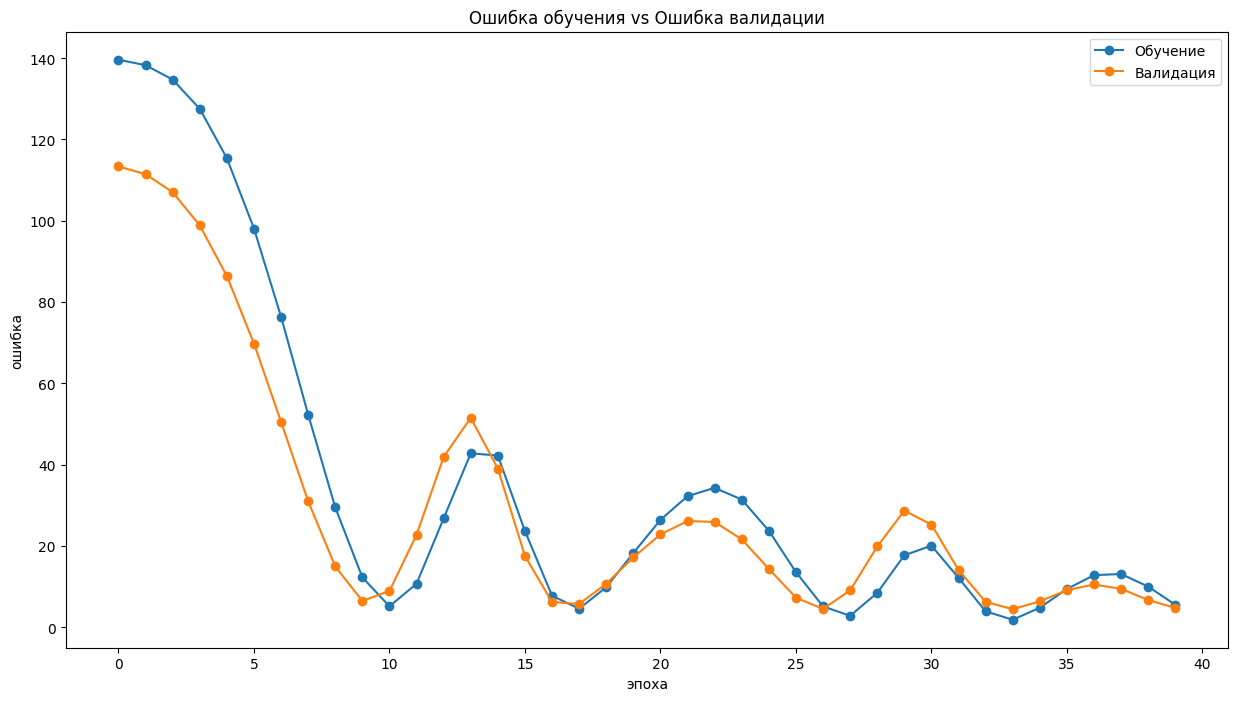

In [231]:
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(train_loss,'-o')
plt.plot(validation_loss,'-o')
plt.xlabel('эпоха')
plt.ylabel('ошибка')
plt.legend(['Обучение','Валидация'])
plt.title('Ошибка обучения vs Ошибка валидации')
plt.show()

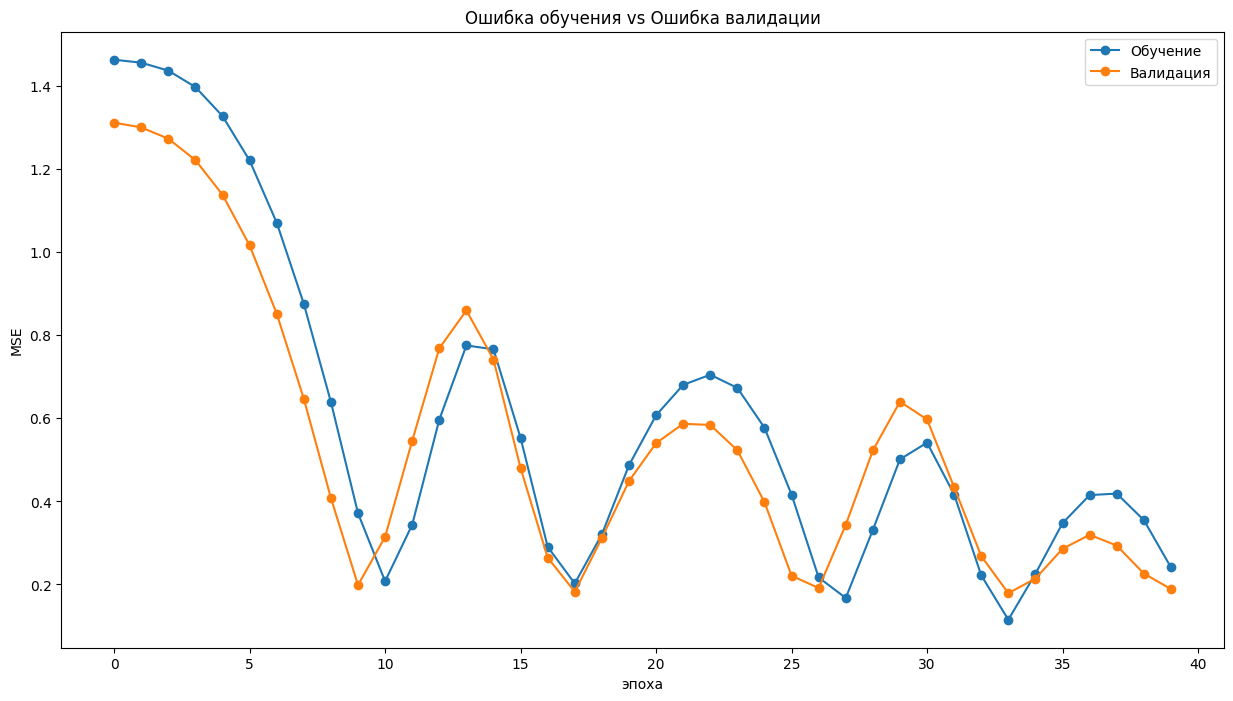

In [232]:
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(MAE_train_loss,'-o')
plt.plot(MAE_validation_loss,'-o')
plt.xlabel('эпоха')
plt.ylabel('MSE')
plt.legend(['Обучение','Валидация'])
plt.title('Ошибка обучения vs Ошибка валидации')
plt.show()

In [233]:
validation(simple_model)

100%|██████████| 67/67 [00:00<00:00, 745.74it/s]

validation loss: 4.792
validation MAE: 0.188


In [234]:
test(simple_model)

100%|██████████| 24/24 [00:00<00:00, 613.86it/s]

test loss: 247.971
test MAE: 10.424 seconds


In [235]:
results = np.array([t.numpy() for t in results]).reshape(-1)

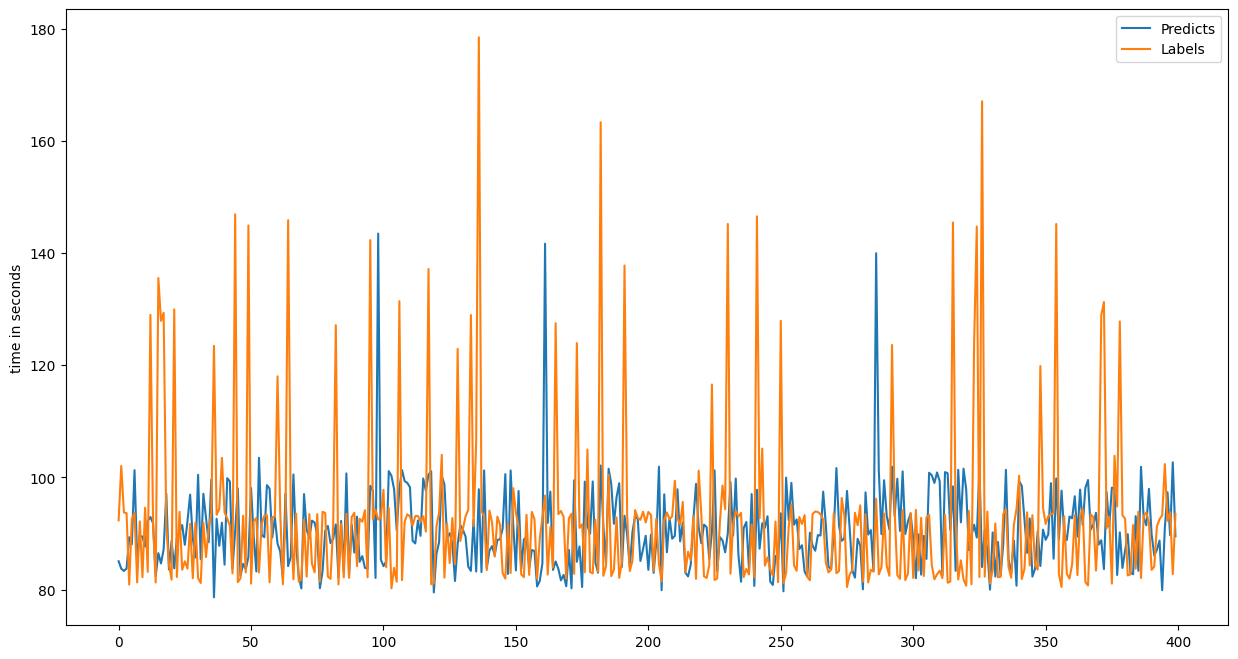

In [238]:
plt.figure()
x_values = np.arange(0, 400)
y_values_1 = results[600:1000]
y_values_2 = y_test.values[600:1000]

sns.lineplot(x=x_values, y=y_values_1, label='Predicts')
sns.lineplot(x=x_values, y=y_values_2, label='Labels')
plt.legend()
plt.ylabel('time in seconds')
plt.show()

Получается, что наша базовая модель на валидации показывает неплохой результат - абсолютная ошибка где-то 0.18 секунды. Попытаемся улучшить имеющийся результат.

На тестовой выборке ошибка модели порядка 10.4 секунды, т.к. данные тяжело описываются (очень много скачков) и полносвязанная модель не может справится с такой зависимостью

In [239]:
class EarlyStopper:
  def __init__(self, patient=1, min_delta=0):
    self.patient = patient
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = float("inf")

  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.counter = 0
      min_validation_loss = validation_loss
    elif validation_loss > self.min_validation_loss + self.min_delta:
      self.counter += 1
      if counter >= patient:
        return True
    return False


In [240]:
class MyNN(nn.Module):
    def __init__(self, num_inputs, num_output=1):
        super().__init__()

        self.activation = nn.GELU()
        self.batch_norm3 = nn.BatchNorm1d(128)
        self.batch_norm5 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(p=0.5)

        self.linear1 = nn.Linear(num_inputs, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 128, bias=False)
        self.linear4 = nn.Linear(128, 64)
        self.linear5 = nn.Linear(64, 64, bias=False)
        self.linear6 = nn.Linear(64, 32)
        self.linear7 = nn.Linear(32, num_output)

        self.skip1 = nn.Linear(256, 128, bias=False)#1-3
        self.skip2 = nn.Linear(256, 64, bias=False)#1-4
        self.skip3 = nn.Linear(256, 64, bias=False)#1-5
        self.skip4 = nn.Linear(256, 32, bias=False)#1-6

    def forward(self, x):
        out = self.linear1(x)
        out = self.activation(out)
        out = self.dropout(out)

        skip1 = out
        skip2 = out
        skip3 = out
        skip4 = out

        out = self.linear2(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.linear3(out)
        out = self.activation(out)
        out = self.batch_norm3(out)

        skip1 = self.skip1(skip1)
        out += skip1

        out = self.linear4(out)
        out = self.activation(out)
        out = self.dropout(out)

        skip2 = self.skip2(skip2)
        out += skip2

        out = self.linear5(out)
        out = self.activation(out)
        out = self.batch_norm5(out)

        skip3 = self.skip3(skip3)
        out += skip3

        out = self.linear6(out)
        out = self.activation(out)
        out = self.dropout(out)

        skip4 = self.skip4(skip4)
        out += skip4

        out = self.linear7(out)
        return out


In [241]:
num_inputs = train_dataset[0][0].shape[0]
model = MyNN(num_inputs, 1).to(device)

In [242]:
from torchinfo import summary
summary(model, input_size=(1, num_inputs))

Layer (type:depth-idx)                   Output Shape              Param #
MyNN                                     [1, 1]                    --
├─Linear: 1-1                            [1, 256]                  49,152
├─GELU: 1-2                              [1, 256]                  --
├─Dropout: 1-3                           [1, 256]                  --
├─Linear: 1-4                            [1, 128]                  32,896
├─GELU: 1-5                              [1, 128]                  --
├─Dropout: 1-6                           [1, 128]                  --
├─Linear: 1-7                            [1, 128]                  16,384
├─GELU: 1-8                              [1, 128]                  --
├─BatchNorm1d: 1-9                       [1, 128]                  256
├─Linear: 1-10                           [1, 128]                  32,768
├─Linear: 1-11                           [1, 64]                   8,256
├─GELU: 1-12                             [1, 64]                 

In [243]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999))

In [244]:
epochs = 80
train_loss = []
MAE_train_loss = []
validation_loss = []
MAE_validation_loss = []
MAE_test_loss = []
best_mae = float("inf")
early_stop = EarlyStopper(patient=10, min_delta=0.05)
for epoch in range(1, epochs + 1):
  print(f"Epoch №{epoch}")
  train(model)
  validation(model)
  if best_mae > MAE_validation_loss[-1]:
    best_mae = MAE_validation_loss[-1]
    torch.save(model, "best-model.pt")
  if early_stop.early_stop(MAE_validation_loss[-1]):
    break

Epoch №1


100%|██████████| 378/378 [00:04<00:00, 89.52it/s] 


train loss: 139.429
train MAE: 1.462


100%|██████████| 67/67 [00:00<00:00, 347.22it/s]


validation loss: 111.997
validation MAE: 1.303
Epoch №2


100%|██████████| 378/378 [00:03<00:00, 104.18it/s]


train loss: 135.247
train MAE: 1.439


100%|██████████| 67/67 [00:00<00:00, 413.76it/s]


validation loss: 107.479
validation MAE: 1.275
Epoch №3


100%|██████████| 378/378 [00:03<00:00, 104.03it/s]


train loss: 128.371
train MAE: 1.400


100%|██████████| 67/67 [00:00<00:00, 360.30it/s]


validation loss: 99.626
validation MAE: 1.225
Epoch №4


100%|██████████| 378/378 [00:04<00:00, 83.22it/s] 


train loss: 117.347
train MAE: 1.336


100%|██████████| 67/67 [00:00<00:00, 409.11it/s]


validation loss: 87.956
validation MAE: 1.146
Epoch №5


100%|██████████| 378/378 [00:03<00:00, 112.51it/s]


train loss: 101.049
train MAE: 1.234


100%|██████████| 67/67 [00:00<00:00, 432.25it/s]


validation loss: 72.219
validation MAE: 1.029
Epoch №6


100%|██████████| 378/378 [00:03<00:00, 104.59it/s]


train loss: 79.640
train MAE: 1.084


100%|██████████| 67/67 [00:00<00:00, 384.21it/s]


validation loss: 52.822
validation MAE: 0.863
Epoch №7


100%|██████████| 378/378 [00:04<00:00, 86.68it/s]


train loss: 55.580
train MAE: 0.881


100%|██████████| 67/67 [00:00<00:00, 432.95it/s]


validation loss: 32.944
validation MAE: 0.646
Epoch №8


100%|██████████| 378/378 [00:03<00:00, 109.43it/s]


train loss: 33.273
train MAE: 0.629


100%|██████████| 67/67 [00:00<00:00, 305.10it/s]


validation loss: 16.958
validation MAE: 0.383
Epoch №9


100%|██████████| 378/378 [00:03<00:00, 103.30it/s]


train loss: 18.605
train MAE: 0.406


100%|██████████| 67/67 [00:00<00:00, 390.02it/s]


validation loss: 9.674
validation MAE: 0.232
Epoch №10


100%|██████████| 378/378 [00:04<00:00, 86.19it/s]


train loss: 16.215
train MAE: 0.369


100%|██████████| 67/67 [00:00<00:00, 230.49it/s]


validation loss: 13.456
validation MAE: 0.369
Epoch №11


100%|██████████| 378/378 [00:03<00:00, 116.11it/s]


train loss: 24.870
train MAE: 0.482


100%|██████████| 67/67 [00:00<00:00, 425.29it/s]


validation loss: 19.943
validation MAE: 0.486
Epoch №12


100%|██████████| 378/378 [00:03<00:00, 114.69it/s]


train loss: 32.499
train MAE: 0.565


100%|██████████| 67/67 [00:00<00:00, 392.88it/s]


validation loss: 22.016
validation MAE: 0.522
Epoch №13


100%|██████████| 378/378 [00:03<00:00, 96.16it/s]


train loss: 33.712
train MAE: 0.575


100%|██████████| 67/67 [00:00<00:00, 217.56it/s]


validation loss: 16.971
validation MAE: 0.450
Epoch №14


100%|██████████| 378/378 [00:04<00:00, 89.97it/s] 


train loss: 25.574
train MAE: 0.495


100%|██████████| 67/67 [00:00<00:00, 304.42it/s]


validation loss: 9.564
validation MAE: 0.311
Epoch №15


100%|██████████| 378/378 [00:03<00:00, 101.72it/s]


train loss: 18.955
train MAE: 0.424


100%|██████████| 67/67 [00:00<00:00, 357.16it/s]


validation loss: 6.892
validation MAE: 0.209
Epoch №16


100%|██████████| 378/378 [00:03<00:00, 104.01it/s]


train loss: 18.294
train MAE: 0.421


100%|██████████| 67/67 [00:00<00:00, 229.38it/s]


validation loss: 8.642
validation MAE: 0.226
Epoch №17


100%|██████████| 378/378 [00:04<00:00, 92.95it/s] 


train loss: 20.511
train MAE: 0.451


100%|██████████| 67/67 [00:00<00:00, 398.91it/s]


validation loss: 10.963
validation MAE: 0.294
Epoch №18


100%|██████████| 378/378 [00:03<00:00, 117.03it/s]


train loss: 21.319
train MAE: 0.467


100%|██████████| 67/67 [00:00<00:00, 430.98it/s]


validation loss: 11.171
validation MAE: 0.301
Epoch №19


100%|██████████| 378/378 [00:03<00:00, 118.69it/s]


train loss: 19.056
train MAE: 0.437


100%|██████████| 67/67 [00:00<00:00, 417.10it/s]


validation loss: 9.107
validation MAE: 0.242
Epoch №20


100%|██████████| 378/378 [00:04<00:00, 88.80it/s]


train loss: 14.584
train MAE: 0.370


100%|██████████| 67/67 [00:00<00:00, 283.08it/s]


validation loss: 6.697
validation MAE: 0.186
Epoch №21


100%|██████████| 378/378 [00:03<00:00, 105.01it/s]


train loss: 10.863
train MAE: 0.309


100%|██████████| 67/67 [00:00<00:00, 428.48it/s]


validation loss: 6.215
validation MAE: 0.218
Epoch №22


100%|██████████| 378/378 [00:03<00:00, 109.70it/s]


train loss: 9.379
train MAE: 0.284


100%|██████████| 67/67 [00:00<00:00, 339.68it/s]


validation loss: 8.196
validation MAE: 0.302
Epoch №23


100%|██████████| 378/378 [00:04<00:00, 91.85it/s]


train loss: 9.911
train MAE: 0.300


100%|██████████| 67/67 [00:00<00:00, 234.70it/s]


validation loss: 10.697
validation MAE: 0.363
Epoch №24


100%|██████████| 378/378 [00:03<00:00, 107.44it/s]


train loss: 10.259
train MAE: 0.311


100%|██████████| 67/67 [00:00<00:00, 414.43it/s]


validation loss: 11.443
validation MAE: 0.378
Epoch №25


100%|██████████| 378/378 [00:03<00:00, 110.65it/s]


train loss: 9.253
train MAE: 0.294


100%|██████████| 67/67 [00:00<00:00, 398.33it/s]


validation loss: 10.430
validation MAE: 0.357
Epoch №26


100%|██████████| 378/378 [00:03<00:00, 97.37it/s]


train loss: 7.483
train MAE: 0.256


100%|██████████| 67/67 [00:00<00:00, 265.17it/s]


validation loss: 8.643
validation MAE: 0.314
Epoch №27


100%|██████████| 378/378 [00:03<00:00, 94.95it/s] 


train loss: 6.150
train MAE: 0.219


100%|██████████| 67/67 [00:00<00:00, 379.30it/s]


validation loss: 7.194
validation MAE: 0.268
Epoch №28


100%|██████████| 378/378 [00:03<00:00, 115.82it/s]


train loss: 5.489
train MAE: 0.198


100%|██████████| 67/67 [00:00<00:00, 399.79it/s]


validation loss: 6.360
validation MAE: 0.230
Epoch №29


100%|██████████| 378/378 [00:03<00:00, 107.32it/s]


train loss: 5.501
train MAE: 0.198


100%|██████████| 67/67 [00:00<00:00, 393.16it/s]


validation loss: 5.925
validation MAE: 0.204
Epoch №30


100%|██████████| 378/378 [00:04<00:00, 91.58it/s] 


train loss: 5.919
train MAE: 0.213


100%|██████████| 67/67 [00:00<00:00, 403.40it/s]


validation loss: 5.905
validation MAE: 0.195
Epoch №31


100%|██████████| 378/378 [00:03<00:00, 111.32it/s]


train loss: 6.360
train MAE: 0.229


100%|██████████| 67/67 [00:00<00:00, 348.92it/s]


validation loss: 5.822
validation MAE: 0.193
Epoch №32


100%|██████████| 378/378 [00:03<00:00, 110.08it/s]


train loss: 6.230
train MAE: 0.228


100%|██████████| 67/67 [00:00<00:00, 419.92it/s]


validation loss: 5.719
validation MAE: 0.194
Epoch №33


100%|██████████| 378/378 [00:04<00:00, 89.18it/s]


train loss: 5.624
train MAE: 0.213


100%|██████████| 67/67 [00:00<00:00, 347.06it/s]


validation loss: 5.684
validation MAE: 0.205
Epoch №34


100%|██████████| 378/378 [00:03<00:00, 107.48it/s]


train loss: 5.020
train MAE: 0.196


100%|██████████| 67/67 [00:00<00:00, 389.27it/s]


validation loss: 6.001
validation MAE: 0.228
Epoch №35


100%|██████████| 378/378 [00:03<00:00, 112.04it/s]


train loss: 4.720
train MAE: 0.189


100%|██████████| 67/67 [00:00<00:00, 447.51it/s]


validation loss: 6.261
validation MAE: 0.243
Epoch №36


100%|██████████| 378/378 [00:03<00:00, 103.94it/s]


train loss: 4.302
train MAE: 0.178


100%|██████████| 67/67 [00:00<00:00, 252.09it/s]


validation loss: 5.886
validation MAE: 0.232
Epoch №37


100%|██████████| 378/378 [00:03<00:00, 99.19it/s] 


train loss: 4.144
train MAE: 0.173


100%|██████████| 67/67 [00:00<00:00, 408.14it/s]


validation loss: 5.287
validation MAE: 0.206
Epoch №38


100%|██████████| 378/378 [00:03<00:00, 110.33it/s]


train loss: 4.307
train MAE: 0.179


100%|██████████| 67/67 [00:00<00:00, 388.31it/s]


validation loss: 5.004
validation MAE: 0.194
Epoch №39


100%|██████████| 378/378 [00:03<00:00, 103.87it/s]


train loss: 4.398
train MAE: 0.184


100%|██████████| 67/67 [00:00<00:00, 209.27it/s]


validation loss: 5.021
validation MAE: 0.202
Epoch №40


100%|██████████| 378/378 [00:04<00:00, 84.45it/s]


train loss: 4.275
train MAE: 0.184


100%|██████████| 67/67 [00:00<00:00, 406.14it/s]


validation loss: 5.236
validation MAE: 0.218
Epoch №41


100%|██████████| 378/378 [00:03<00:00, 112.32it/s]


train loss: 4.341
train MAE: 0.189


100%|██████████| 67/67 [00:00<00:00, 411.99it/s]


validation loss: 5.159
validation MAE: 0.218
Epoch №42


100%|██████████| 378/378 [00:03<00:00, 118.72it/s]


train loss: 4.303
train MAE: 0.189


100%|██████████| 67/67 [00:00<00:00, 441.61it/s]


validation loss: 4.687
validation MAE: 0.195
Epoch №43


100%|██████████| 378/378 [00:04<00:00, 84.44it/s] 


train loss: 4.277
train MAE: 0.188


100%|██████████| 67/67 [00:00<00:00, 363.93it/s]


validation loss: 4.540
validation MAE: 0.188
Epoch №44


100%|██████████| 378/378 [00:03<00:00, 110.18it/s]


train loss: 4.027
train MAE: 0.184


100%|██████████| 67/67 [00:00<00:00, 362.78it/s]


validation loss: 4.559
validation MAE: 0.192
Epoch №45


100%|██████████| 378/378 [00:03<00:00, 109.00it/s]


train loss: 3.825
train MAE: 0.180


100%|██████████| 67/67 [00:00<00:00, 351.64it/s]


validation loss: 4.591
validation MAE: 0.195
Epoch №46


100%|██████████| 378/378 [00:04<00:00, 84.26it/s]


train loss: 3.738
train MAE: 0.181


100%|██████████| 67/67 [00:00<00:00, 198.89it/s]


validation loss: 4.445
validation MAE: 0.185
Epoch №47


100%|██████████| 378/378 [00:03<00:00, 111.09it/s]


train loss: 3.524
train MAE: 0.174


100%|██████████| 67/67 [00:00<00:00, 434.93it/s]


validation loss: 4.457
validation MAE: 0.182
Epoch №48


100%|██████████| 378/378 [00:03<00:00, 116.77it/s]


train loss: 3.499
train MAE: 0.173


100%|██████████| 67/67 [00:00<00:00, 395.85it/s]


validation loss: 4.591
validation MAE: 0.184
Epoch №49


100%|██████████| 378/378 [00:03<00:00, 109.61it/s]


train loss: 3.438
train MAE: 0.172


100%|██████████| 67/67 [00:00<00:00, 253.16it/s]


validation loss: 4.830
validation MAE: 0.189
Epoch №50


100%|██████████| 378/378 [00:03<00:00, 98.60it/s] 


train loss: 3.649
train MAE: 0.178


100%|██████████| 67/67 [00:00<00:00, 408.85it/s]


validation loss: 5.154
validation MAE: 0.197
Epoch №51


100%|██████████| 378/378 [00:03<00:00, 109.01it/s]


train loss: 3.826
train MAE: 0.182


100%|██████████| 67/67 [00:00<00:00, 352.75it/s]


validation loss: 5.543
validation MAE: 0.205
Epoch №52


100%|██████████| 378/378 [00:03<00:00, 104.77it/s]


train loss: 4.100
train MAE: 0.185


100%|██████████| 67/67 [00:00<00:00, 433.30it/s]


validation loss: 5.771
validation MAE: 0.209
Epoch №53


100%|██████████| 378/378 [00:04<00:00, 84.27it/s] 


train loss: 4.016
train MAE: 0.183


100%|██████████| 67/67 [00:00<00:00, 341.79it/s]


validation loss: 5.712
validation MAE: 0.206
Epoch №54


100%|██████████| 378/378 [00:03<00:00, 106.60it/s]


train loss: 4.200
train MAE: 0.182


100%|██████████| 67/67 [00:00<00:00, 344.03it/s]


validation loss: 5.588
validation MAE: 0.201
Epoch №55


100%|██████████| 378/378 [00:03<00:00, 109.84it/s]


train loss: 4.291
train MAE: 0.179


100%|██████████| 67/67 [00:00<00:00, 402.03it/s]


validation loss: 5.525
validation MAE: 0.195
Epoch №56


100%|██████████| 378/378 [00:04<00:00, 90.80it/s] 


train loss: 4.297
train MAE: 0.174


100%|██████████| 67/67 [00:00<00:00, 395.30it/s]


validation loss: 5.433
validation MAE: 0.192
Epoch №57


100%|██████████| 378/378 [00:03<00:00, 116.13it/s]


train loss: 4.075
train MAE: 0.171


100%|██████████| 67/67 [00:00<00:00, 422.32it/s]


validation loss: 5.291
validation MAE: 0.192
Epoch №58


100%|██████████| 378/378 [00:03<00:00, 118.31it/s]


train loss: 3.929
train MAE: 0.170


100%|██████████| 67/67 [00:00<00:00, 401.19it/s]


validation loss: 5.228
validation MAE: 0.194
Epoch №59


100%|██████████| 378/378 [00:03<00:00, 97.55it/s]


train loss: 3.968
train MAE: 0.168


100%|██████████| 67/67 [00:00<00:00, 237.66it/s]


validation loss: 5.151
validation MAE: 0.192
Epoch №60


100%|██████████| 378/378 [00:03<00:00, 101.47it/s]


train loss: 3.716
train MAE: 0.166


100%|██████████| 67/67 [00:00<00:00, 389.11it/s]


validation loss: 5.033
validation MAE: 0.193
Epoch №61


100%|██████████| 378/378 [00:03<00:00, 114.79it/s]


train loss: 3.715
train MAE: 0.166


100%|██████████| 67/67 [00:00<00:00, 352.24it/s]


validation loss: 4.884
validation MAE: 0.193
Epoch №62


100%|██████████| 378/378 [00:03<00:00, 111.02it/s]


train loss: 3.389
train MAE: 0.161


100%|██████████| 67/67 [00:00<00:00, 369.70it/s]


validation loss: 4.720
validation MAE: 0.189
Epoch №63


100%|██████████| 378/378 [00:04<00:00, 84.27it/s] 


train loss: 3.435
train MAE: 0.162


100%|██████████| 67/67 [00:00<00:00, 368.91it/s]


validation loss: 4.592
validation MAE: 0.189
Epoch №64


100%|██████████| 378/378 [00:03<00:00, 113.26it/s]


train loss: 3.383
train MAE: 0.162


100%|██████████| 67/67 [00:00<00:00, 414.01it/s]


validation loss: 4.501
validation MAE: 0.186
Epoch №65


100%|██████████| 378/378 [00:03<00:00, 117.97it/s]


train loss: 3.202
train MAE: 0.159


100%|██████████| 67/67 [00:00<00:00, 429.76it/s]


validation loss: 4.424
validation MAE: 0.186
Epoch №66


100%|██████████| 378/378 [00:04<00:00, 89.69it/s]


train loss: 3.199
train MAE: 0.161


100%|██████████| 67/67 [00:00<00:00, 206.14it/s]


validation loss: 4.383
validation MAE: 0.184
Epoch №67


100%|██████████| 378/378 [00:03<00:00, 99.02it/s] 


train loss: 3.155
train MAE: 0.161


100%|██████████| 67/67 [00:00<00:00, 428.52it/s]


validation loss: 4.359
validation MAE: 0.185
Epoch №68


100%|██████████| 378/378 [00:03<00:00, 108.78it/s]


train loss: 3.285
train MAE: 0.163


100%|██████████| 67/67 [00:00<00:00, 444.80it/s]


validation loss: 4.358
validation MAE: 0.187
Epoch №69


100%|██████████| 378/378 [00:03<00:00, 103.17it/s]


train loss: 3.161
train MAE: 0.161


100%|██████████| 67/67 [00:00<00:00, 265.07it/s]


validation loss: 4.391
validation MAE: 0.187
Epoch №70


100%|██████████| 378/378 [00:03<00:00, 99.92it/s] 


train loss: 3.257
train MAE: 0.165


100%|██████████| 67/67 [00:00<00:00, 418.73it/s]


validation loss: 4.466
validation MAE: 0.190
Epoch №71


100%|██████████| 378/378 [00:03<00:00, 114.60it/s]


train loss: 3.397
train MAE: 0.168


100%|██████████| 67/67 [00:00<00:00, 386.73it/s]


validation loss: 4.525
validation MAE: 0.192
Epoch №72


100%|██████████| 378/378 [00:03<00:00, 111.88it/s]


train loss: 3.433
train MAE: 0.171


100%|██████████| 67/67 [00:00<00:00, 370.74it/s]


validation loss: 4.554
validation MAE: 0.191
Epoch №73


100%|██████████| 378/378 [00:04<00:00, 88.53it/s] 


train loss: 3.649
train MAE: 0.176


100%|██████████| 67/67 [00:00<00:00, 362.36it/s]


validation loss: 4.563
validation MAE: 0.192
Epoch №74


100%|██████████| 378/378 [00:03<00:00, 109.77it/s]


train loss: 3.813
train MAE: 0.181


100%|██████████| 67/67 [00:00<00:00, 386.45it/s]


validation loss: 4.597
validation MAE: 0.194
Epoch №75


100%|██████████| 378/378 [00:03<00:00, 109.93it/s]


train loss: 3.986
train MAE: 0.186


100%|██████████| 67/67 [00:00<00:00, 377.87it/s]


validation loss: 4.515
validation MAE: 0.190
Epoch №76


100%|██████████| 378/378 [00:04<00:00, 85.24it/s]


train loss: 4.223
train MAE: 0.192


100%|██████████| 67/67 [00:00<00:00, 402.51it/s]


validation loss: 4.529
validation MAE: 0.193
Epoch №77


100%|██████████| 378/378 [00:03<00:00, 111.63it/s]


train loss: 4.333
train MAE: 0.196


100%|██████████| 67/67 [00:00<00:00, 384.79it/s]


validation loss: 4.525
validation MAE: 0.191
Epoch №78


100%|██████████| 378/378 [00:03<00:00, 103.95it/s]


train loss: 4.488
train MAE: 0.200


100%|██████████| 67/67 [00:00<00:00, 387.61it/s]


validation loss: 4.577
validation MAE: 0.194
Epoch №79


100%|██████████| 378/378 [00:03<00:00, 97.12it/s]


train loss: 4.539
train MAE: 0.201


100%|██████████| 67/67 [00:00<00:00, 225.72it/s]


validation loss: 4.512
validation MAE: 0.191
Epoch №80


100%|██████████| 378/378 [00:03<00:00, 107.95it/s]


train loss: 4.659
train MAE: 0.204


100%|██████████| 67/67 [00:00<00:00, 389.72it/s]

validation loss: 4.494
validation MAE: 0.193


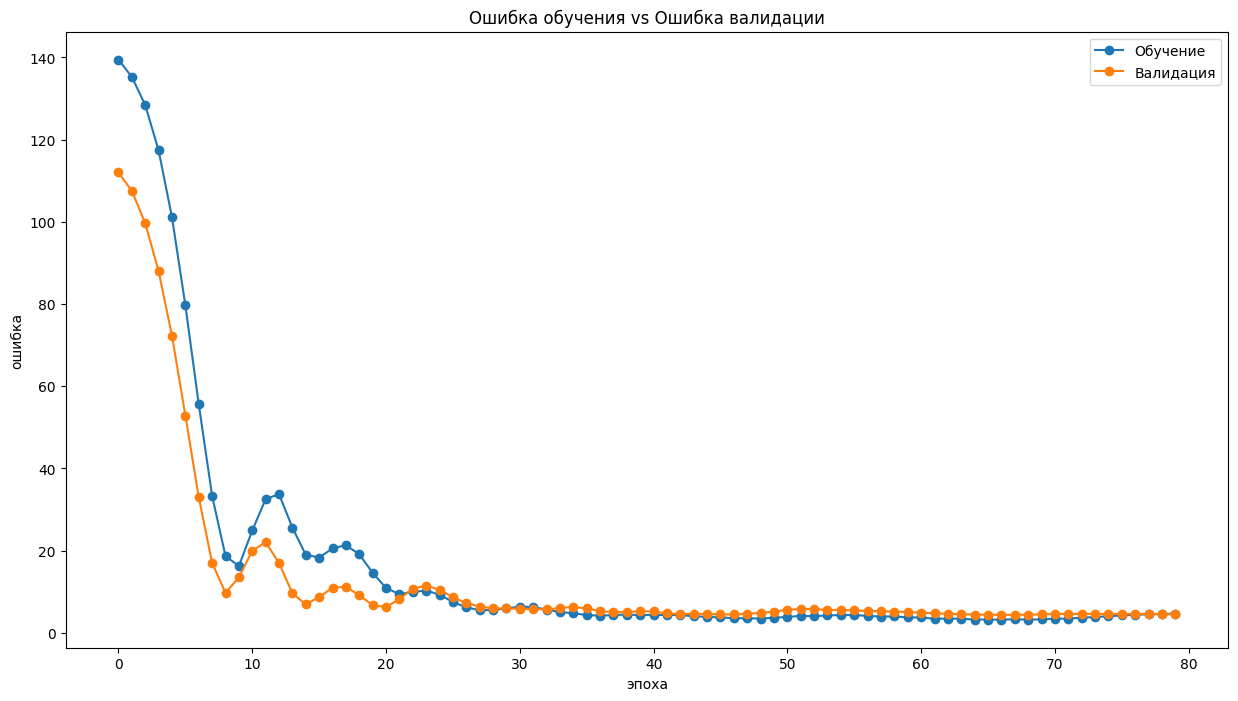

In [245]:
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(train_loss,'-o')
plt.plot(validation_loss,'-o')
plt.xlabel('эпоха')
plt.ylabel('ошибка')
plt.legend(['Обучение','Валидация'])
plt.title('Ошибка обучения vs Ошибка валидации')
plt.show()

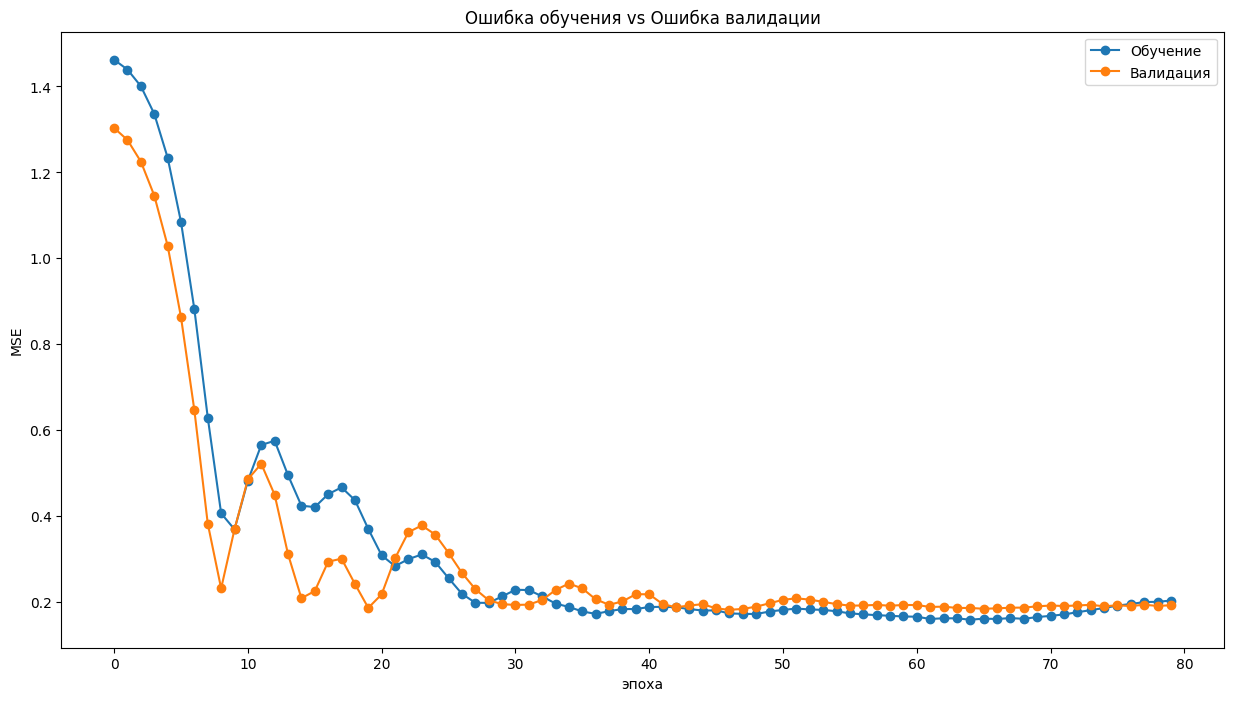

In [246]:
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(MAE_train_loss,'-o')
plt.plot(MAE_validation_loss,'-o')
plt.xlabel('эпоха')
plt.ylabel('MSE')
plt.legend(['Обучение','Валидация'])
plt.title('Ошибка обучения vs Ошибка валидации')
plt.show()

In [247]:
print(best_mae)

0.18197805870306882


In [248]:
best_model = torch.load('best-model.pt');
best_model.eval();

In [251]:
test(best_model)

100%|██████████| 24/24 [00:00<00:00, 339.29it/s]

test loss: 228.051
test MAE: 9.543 seconds


In [252]:
results = np.array([t.numpy() for t in results]).reshape(-1)

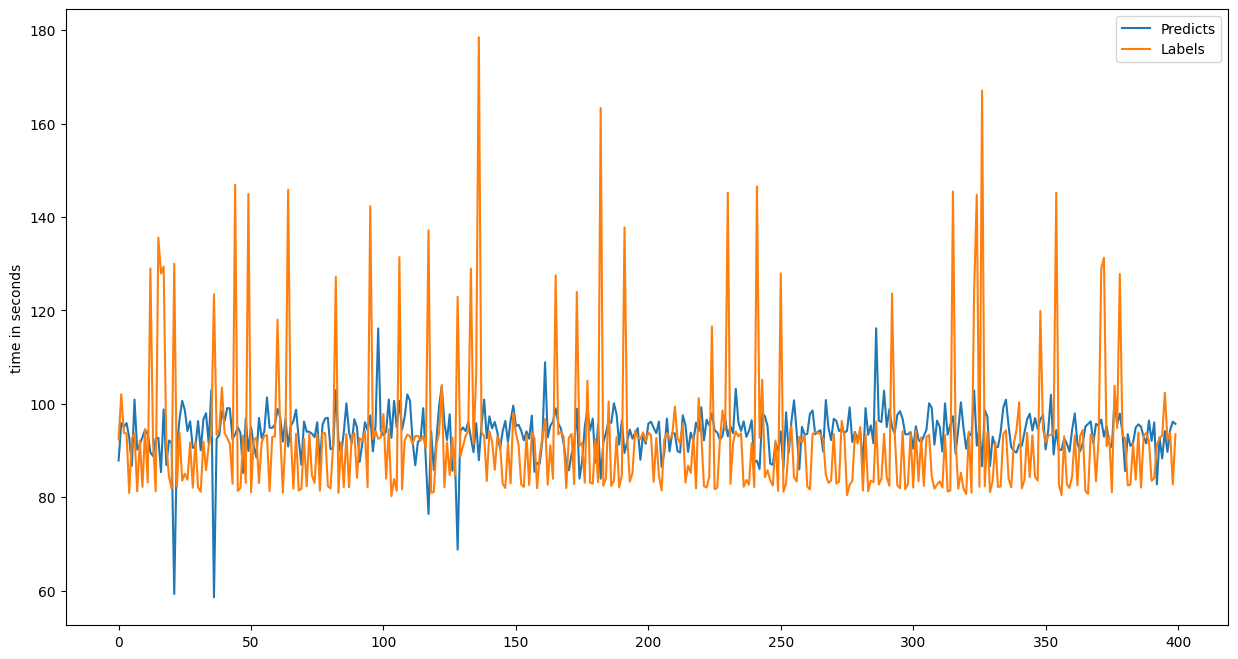

In [253]:
plt.figure()
x_values = np.arange(0, 400)
y_values_1 = results[600:1000]
y_values_2 = y_test.values[600:1000]

sns.lineplot(x=x_values, y=y_values_1, label='Predicts')
sns.lineplot(x=x_values, y=y_values_2, label='Labels')
plt.legend()
plt.ylabel('time in seconds')
plt.show()

Модель при обучении показала лучший результат ошибки на тестовых данных - 9.5 секунды, что на 0.9 секунды лучше базовой модели. Для достижения данного результата была введена батч-нормализация и дропаут. Также более глубокая сеть дала небольшой прирост в метриках и дольше переобучалась по сравнению с сетью с широкими слоями, но в увеличением слоев явно появлялась проблема затухания градиентов, поэтому я добавил несколько skip-connection. Также вместо обычного ReLU, который зануляет градиенты, я использовал GELU (да он намного дольше считается при сравнении с ReLU, но на маленьких сетях дает чуть лучший результат). В итоге количество обучаемых параметров увеличилось чуть больше, чем в два раза по сравнению с базовой моделью, но с помощью методов регуляризации удалось добиться чуть лучшего результата